# AutoEncoder: Self-Supervised Classifier
#### by Pio Lauren T. Mendoza


#### Importing the modules needed.

In [47]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt

from munkres import Munkres

import numpy as np

from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend as K

In [48]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Importing MNIST dataset.

In [60]:
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()

#### Data Preprocessing
Normalizing the images/ Converting to binary.

In [61]:
xTrain, xTest = xTrain.astype('float32')/255, xTest.astype('float32')/255
imgShape = xTrain.shape[1:]
xTrain, xTest = xTrain.reshape([-1, *imgShape, 1]), xTest.reshape([-1, *imgShape, 1])

#### plotDatasetSample
This functions plots 25 samples from the MNIST dataset in a square with shape of side of 5.

In [46]:
def plotDatasetSample(dataset0, title0, dataset1 = None,  title1 = None):
    # Get image width and height
    imgSize = dataset0.shape[1:]
    
    # Get 25 random samples
    indices = np.random.choice(range(dataset0.shape[0]), size=25, replace=False)
    
    # Reshape into square
    imgs = dataset0[indices].reshape(5, 5, imgSize[0], imgSize[1])
    imgs = np.vstack([np.hstack(i) for i in imgs])
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(imgs, cmap='gray')
    plt.axis('off')
    plt.title(title0)
    
    # if second dataset it available
    if dataset1 is not None:
        imgs1 = dataset1[indices].reshape(5, 5, imgSize[0], imgSize[1])
        imgs1 = np.vstack([np.hstack(i) for i in imgs1])
        plt.subplot(1,2,2)
        plt.imshow(imgs1, cmap='gray')
        plt.axis('off')
        plt.title(title1)
    plt.tight_layout()
    plt.show()

Samples from the MNIST dataset.

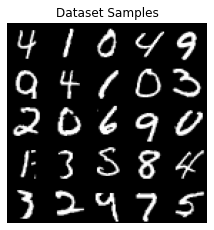

In [57]:
plotDatasetSample(xTrain, 'Dataset Samples')

### Building the autoencoder model.
I'm using a simple model with 6 layers of cnn and 3 layers of mlp.
The encoder has layers of cnn with $128, 64, 32$ slices and an mlp layer with $32$ units while the decoder has the transpose of it. The latent vector will have a $16$ units. The cnn layers will have a filter size of 3.

#### Defining hyper-parameters

In [58]:
layers = [2**i for i in range(7, 4, -1)]
kernelSize = 3
mlpDim = 32
latentDim = 16
epochs = 40
batchSize = 64

The models will be divided into 2 parts namely, encoder and decoder. This is essential since the clustering will happen in the layer with the latent vector (bottle neck layer/ feature vector), this is the output of the encoder.

#### Encoder

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoderInput (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 128)       1280      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 32)          18464     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                50208     
_________________________________________________________________
latentVector (Dense)         (None, 16)                528 

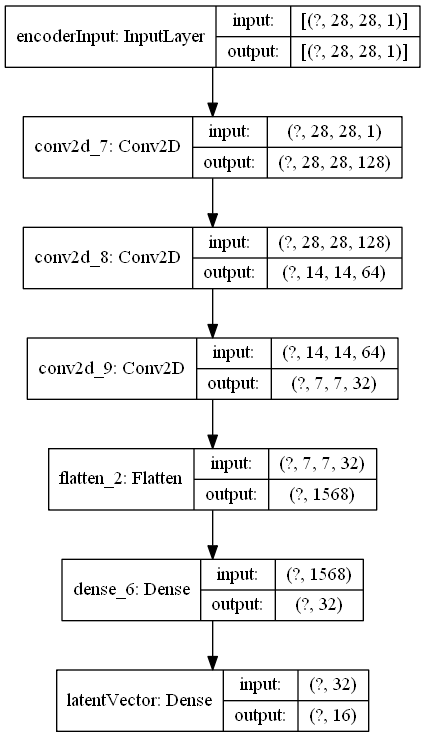

In [62]:
# Getting the image shape


inputs = Input(shape=(*imgShape, 1), name="encoderInput")

x = inputs 
for filters in layers:
    x = Conv2D(filters=filters,
               kernel_size=kernelSize,
               activation='relu',
               padding='same',
               strides= 1 if filters == 128 else 2)(x)

# this is needed later when reshaping from mlp to cnn input
shapeCnn = K.int_shape(x)
    
x = Dense(units=mlpDim,
          activation='relu')(Flatten()(x))

latentVector = Dense(units=latentDim,
                     activation='relu',
                     name = 'latentVector')(x)
encoder = Model(inputs, latentVector, name='encoder')

encoder.summary()

plot_model(encoder, show_shapes=True)

#### Decoder

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoderInput (InputLayer)    [(None, 16)]              0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_8 (Dense)              (None, 1568)              51744     
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 28, 28, 128)       7385

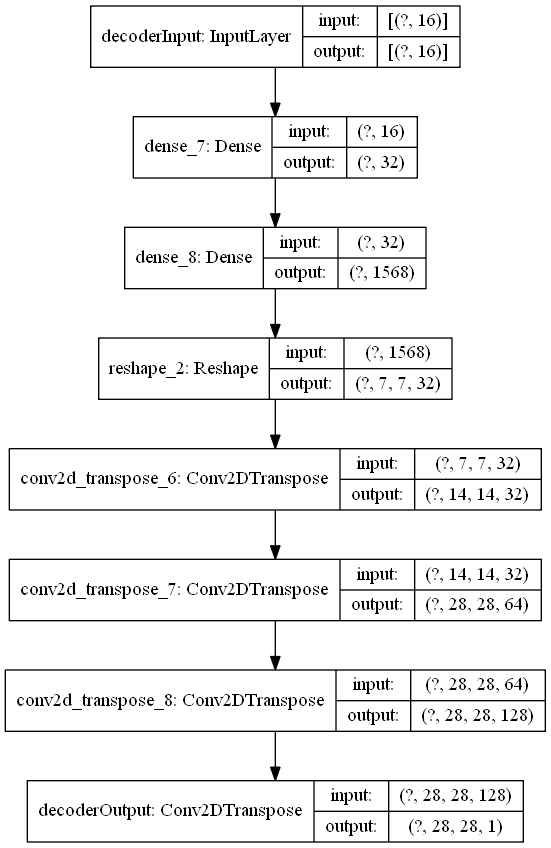

In [63]:
latentInputs = Input(shape=(latentDim,), name='decoderInput')

x = Dense(units=mlpDim,
          activation='relu')(latentInputs)

x = Dense(units=np.prod(shapeCnn[1:]),
          activation='relu')(x)

x = Reshape(target_shape=shapeCnn[1:])(x)

for filters in layers[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernelSize,
                        activation='relu',
                        padding='same',
                        strides= 1 if filters == 128 else 2)(x)

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernelSize,
                          activation='sigmoid',
                          padding='same',
                          name='decoderOutput')(x)

decoder = Model(latentInputs, outputs, name='decoder')

decoder.summary()

plot_model(decoder, show_shapes=True)

#### Autoencoder
After building the encoder and decoder, it must stacked together and compiled as one.

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoderInput (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 16)                144272    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         155041    
Total params: 299,313
Trainable params: 299,313
Non-trainable params: 0
_________________________________________________________________


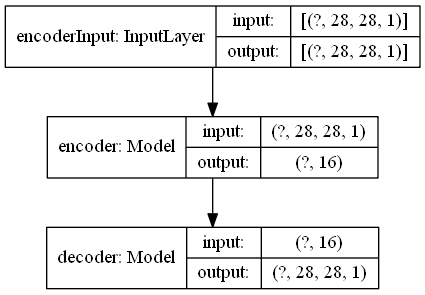

In [64]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

autoencoder.summary()

plot_model(autoencoder, show_shapes=True)

#### Pretraining the model

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 15s 250us/sample - loss: 0.0315 - val_loss: 0.0168
Epoch 2/40
60000/60000 [==============================] - 14s 236us/sample - loss: 0.0143 - val_loss: 0.0126
Epoch 3/40
60000/60000 [==============================] - 14s 238us/sample - loss: 0.0119 - val_loss: 0.0111
Epoch 4/40
60000/60000 [==============================] - 14s 238us/sample - loss: 0.0108 - val_loss: 0.0106
Epoch 5/40
60000/60000 [==============================] - 14s 240us/sample - loss: 0.0101 - val_loss: 0.0101
Epoch 6/40
60000/60000 [==============================] - 14s 240us/sample - loss: 0.0097 - val_loss: 0.0093
Epoch 7/40
60000/60000 [==============================] - 15s 242us/sample - loss: 0.0093 - val_loss: 0.0092
Epoch 8/40
60000/60000 [==============================] - 15s 244us/sample - loss: 0.0091 - val_loss: 0.0090
Epoch 9/40
60000/60000 [==============================] - 15s 245us/sample - l

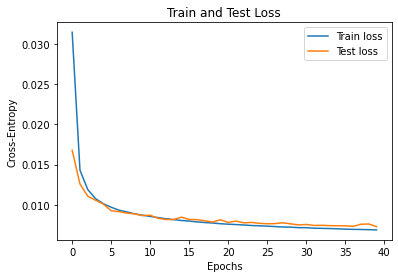

In [65]:
# binary crossentropy is a better loss functions since the values are either 1 or 0
autoencoder.compile(loss='mse', optimizer='adam')

history = autoencoder.fit(xTrain,
                          xTrain,
                          validation_data=(xTest, xTest),
                          epochs=epochs,
                          batch_size=batchSize)

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.title('Train and Test Loss')
plt.ylabel('Cross-Entropy')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

#### Predicting Output
This will predict the output based on input xTest. 

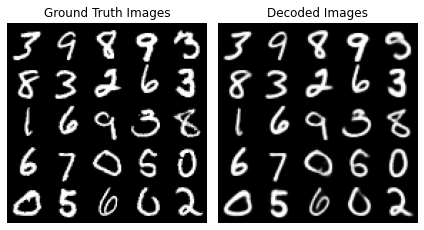

In [66]:
xDecoded = autoencoder.predict(xTest)
plotDatasetSample(xTest, 'Ground Truth Images', xDecoded, 'Decoded Images')

As we could see the auto encoder was able to recreate the input. The output have some minor deviation from the input but overall the output is very close to the input. Variable features contains the latent vectors of the inputs.

In [68]:
features = encoder.predict(xTest)

Preprocessing the data will be useful. Standardization of the data can be done by subtracting the mean of the latent vector and dividing it by the standard deviation.

let $x$ be the latent vector and $\hat{\textbf{$x$}}$ the stadardized laten vector.
$$\hat{\textbf{$x$}} = \frac{\textbf{$x$} - \mu}{\delta}$$

In [14]:
def standardize(x):
    """
    input: row feature vectors stacked vertically
    output: standardize feature vectors stacked vertically
    """
    mean = np.mean(x, axis=1)
    std = np.std(x, axis=1)
    return (x-mean[:, np.newaxis])/std[:, np.newaxis]

The KMeans algorithm is as follows:
1. Initialize k cluster centroids. (easiest way is to just randomly pick k vectors)
2. While the centroids still change
    1. Assign the vectors to the cluster with nearest centroid 
    2. Compute the new centroid as the mean of the cluster

#### Initialize Centroids
This function picks kClusters of feature vectors.

In [15]:
def initCentroids(x, kClusters):
    """
    input: row feature vectors stacked vertically
    output: kClusters standardize feature vectors stacked vertically
    """
    indices = np.random.choice(range(x.shape[0]), size=kClusters, replace=False)
    return x[indices, :]

#### Closest Centroid
This functions looks for the nearest centroids of the feature vectors.

In [16]:
def closestCentroid(x, centroids):
    """
    inpust: row feature vectors stacked vertically, 
            vertically stacked centroids
    output: indices of the nearest centroid per feature vectors, row vector
    """
    distances = np.sqrt(((x - centroids[:, np.newaxis])**2).sum(axis=2))
    return np.argmin(distances, axis=0)
#     minDistances = distances[indices, np.arange(distances.shape[1])]
#     return indices, minDistances

#### Compute Centroid
Computes the new centroids based on the means of the clusters.

In [111]:
def computeCentroid(x, clusters, centroids):
    """
    inpust: row feature vectors stacked vertically, 
            cluster vector where each feature belongs,
            vertically stacked centroids,
    output: new centroids of each cluster
    """
    return np.array([x[clusters==k].mean(axis=0) for k in range(centroids.shape[0])])

#### Fit KMeans
Computes for the feature vectors clusters based on the number of given clusters and iterations

In [112]:
def fitKmean(x, kClusters, iterations):
    """
    inpust: row feature vectors stacked vertically, 
            number of clusters,
            vertically stacked centroids,
    output: clusters of x
    """
    centroids = initCentroids(x, kClusters)
    sameCluster = False
    it = 0
    oldClusters = np.zeros(x.shape[0])
    while it < iterations and not sameCluster:
        clusters = closestCentroid(x, centroids)
#         plotClusters(x, clusters, kClusters)
        if np.all(clusters == oldClusters):
            sameCluster = True
            continue
        oldClusters = clusters
        centroids = computeCentroid(x, clusters, centroids)
    return clusters

In [113]:
# This was used to visually test the code in 2d feature vectors
def plotClusters(x, clusters, kClusters):
    for i in range(kClusters):
        plt.scatter(x[i==clusters, 0], x[i==clusters, 1])
    plt.show()

[7 2 1 ... 4 5 6]


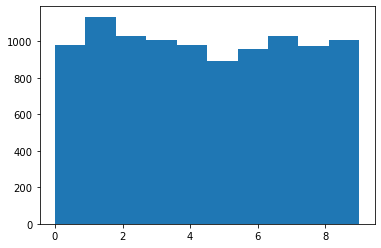

[4 3 0 ... 8 8 2]


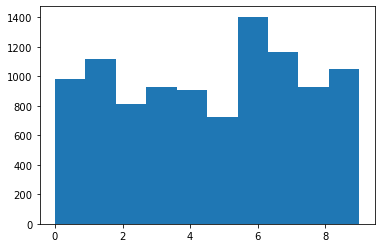

In [87]:
a = np.vstack((np.random.rand(4,2) + np.array([[0,0]]), np.random.rand(4,2) + np.array([[1,1]]), np.random.rand(4,2) + np.array([[.5,0]])))
clusters = fitKmean(standardize(features), 10, 300)
print(yTest)
plt.hist(yTest, 10)
plt.show()
print(clusters)
plt.hist(clusters, 10)
plt.show()

The cost matrix must be defined before using the Hungarian algorithm. <br/>
The negative count of the index with matching permutated groundtruth labels and cluster labels. <br/>
Example:<br/>
cluster labels:   [0, 1, 0, 0, 1, 1]<br/>
ground truth:       [0, 1, 0, 1, 0, 1]<br/>
cost matrix: <br/>

|cluster labels\ground truth     | 0   | 1   |
|:------------------------------:|:---:|:---:|
|0                               |-2   |-1   |
|1                               |-1   |-2   |



#### Compute Cost Matrix
This functions computes the cost matrix. The cost matrix is a square matrix since the comparison will be done for all the permuation of the cluster labels and the ground truth labels. 

In [114]:
def computeCostMatrix(x0, x1):
    """
    inputs: two arrays, "worker" = cluster label, "task" = ground truth label
    outpus: a square matrix, cost matrix
    """
    x0Labels = np.unique(x0)
    x1Labels = np.unique(x1)
    return np.array([[-np.intersect1d(np.nonzero(x0 == x0Label), np.nonzero(x1 == x1Label)).shape[0] for x1Label in x1Labels] for x0Label in x0Labels])

#### Hungarian Algorithm
Hungarian algorithm is an assignment algorithm. It uses a loss or confusion matrix which determines what will be assigned to which entity. The row entities are the one that must be assigned to the column entities. It is a recursive process which has time a complexicy of $O(n^4)$. Some optimazations where done in the past that lessened the time complexity to $O(n^3)$. <br/>

For n entities that must be assigned to n labels. The algo will be:<br/>

While not all are labelled:<br/>
1. Subtract row minima<br/>
    * For each row, find the lowest element and subtract it from each element in that row.<br/>
2. Subtract column minima<br/>
    * Similarly, for each column, find the lowest element and subtract it from each element in that column.<br/>
3. Cover all zeros with a minimum number of lines<br/>
    * Cover all zeros in the resulting matrix using a minimum number of horizontal and vertical lines. If n lines are required, an optimal assignment exists among the zeros. The algorithm stops.<br/>
    * If less than n lines are required, continue with Step 4.<br/>
4. Create additional zeros<br/>
    * Find the smallest element (call it k) that is not covered by a line in Step 3. Subtract k from all uncovered elements, and add k to all elements that are covered twice.
    
Source: http://www.hungarianalgorithm.com/

In [115]:
# Compute Cost of the cluster labels and ground truth labels
clusters = clusters
cost = computeCostMatrix(clusters, yTest)

hungarianAlgo = Munkres()
mapping = hungarianAlgo.compute(cost)

mapper = {}

for cluster, labelPredict in mapping:
    print(f"Cluster {cluster} is labeled as digit {labelPredict}")
    mapper[cluster] = labelPredict
    
# mapping cluster label to predict label
yPredict = np.array([mapper[i] for i in clusters])

# Check accuracy
accuracy = np.sum(yPredict == yTest)*100.0/yPredict.shape[0]
print(f"The accuracy is : {accuracy}%")


Cluster 0 is labeled as digit 1
Cluster 1 is labeled as digit 3
Cluster 2 is labeled as digit 6
Cluster 3 is labeled as digit 2
Cluster 4 is labeled as digit 7
Cluster 5 is labeled as digit 4
Cluster 6 is labeled as digit 8
Cluster 7 is labeled as digit 0
Cluster 8 is labeled as digit 5
Cluster 9 is labeled as digit 9
The accuracy is : 75.86%


#### Sample Labelling

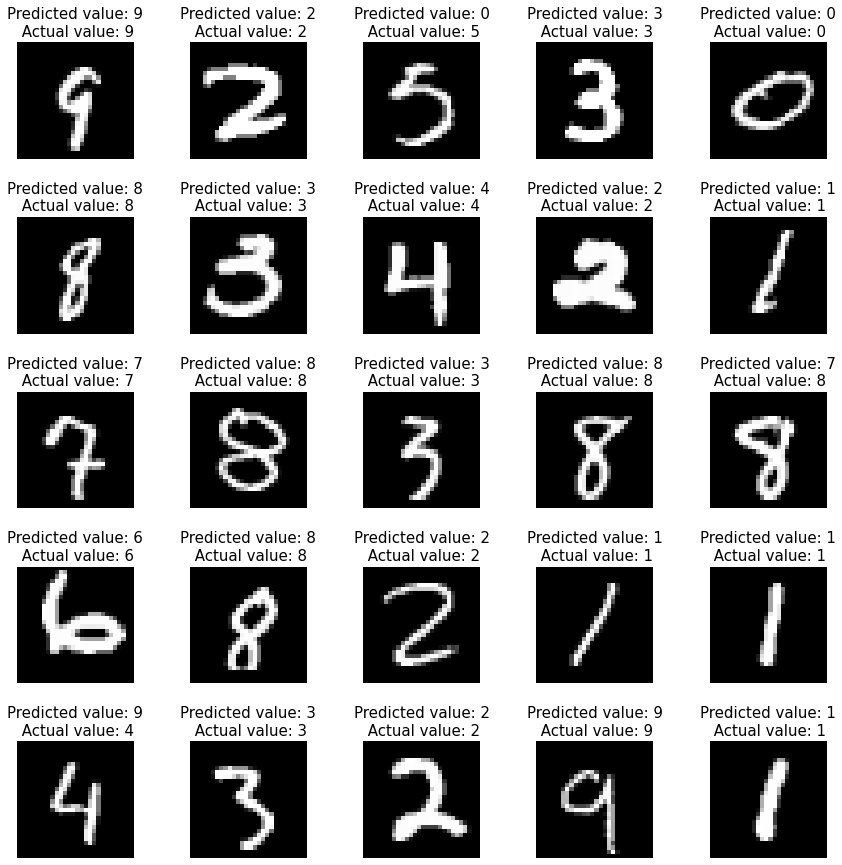

In [123]:
indices = np.random.choice(range(xTest.shape[0]), size=25, replace=False)

plt.subplots(5, 5, figsize=(15, 15))
for i, idx in enumerate(indices):
    plt.subplot(5, 5, i+1)
    plt.imshow(xTest[idx], cmap='gray')
    plt.axis('off')
    plt.title(f'Predicted value: {yPredict[idx]}\n Actual value: {yTest[idx]}', fontsize=15)

space = .5
plt.subplots_adjust(hspace=hspace)
plt.show()

As seen from the results, the encoder, from the pretrained autoencoder, Kmeans, and Hungarian algorithm stack was able to label the MNIST dataset. It has an accuracy of **75.86%**. The mislabeled numbers are usually the numbers that has a similar pattern with another number. Like the lower-right most sample, 4 was mislabelled as 9. Number 4 and 9 have similar which caused this mislabelling.